In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import libraries for Data Visualisation

In [2]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

Data Loading

In [5]:
train_df = pd.read_csv('../data/train.csv', low_memory=False)
test_df = pd.read_csv('../data/test.csv')
store_df = pd.read_csv('../data/store.csv')
submission_df = pd.read_csv('../data/sample_submission.csv')

Merge Store dataset and Train/Test datasets

In [6]:
merged_df = train_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

EDA

In [7]:
merged_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

<Axes: xlabel='Sales', ylabel='Count'>

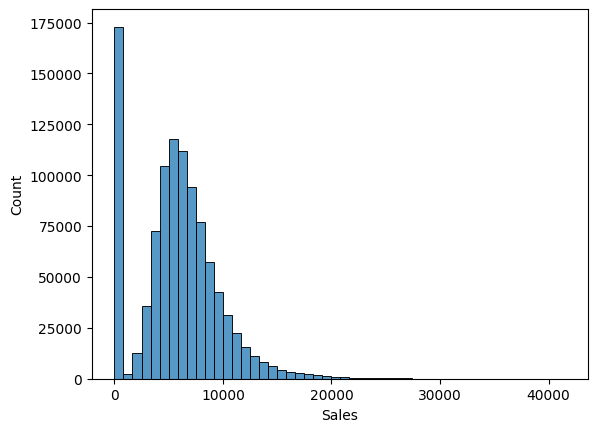

In [8]:
sns.histplot(merged_df['Sales'], bins=50)

<Axes: >

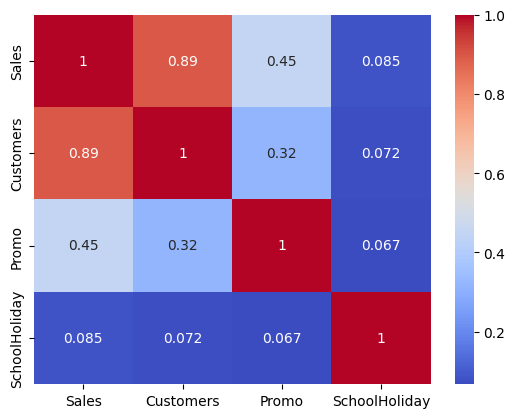

In [9]:
corr = merged_df[['Sales', 'Customers', 'Promo', 'SchoolHoliday']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

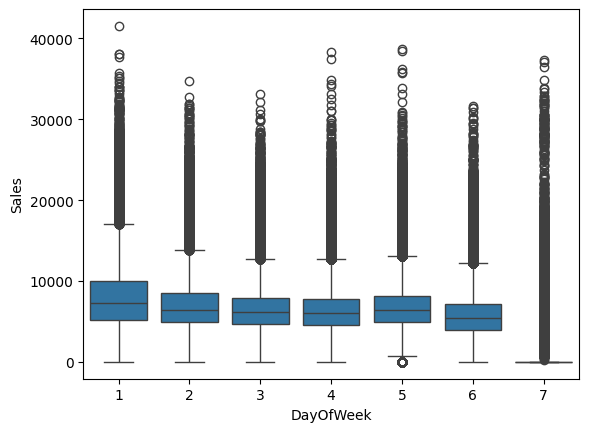

In [10]:
sns.boxplot(x='DayOfWeek', y='Sales', data=merged_df)

<Axes: xlabel='Promo', ylabel='Sales'>

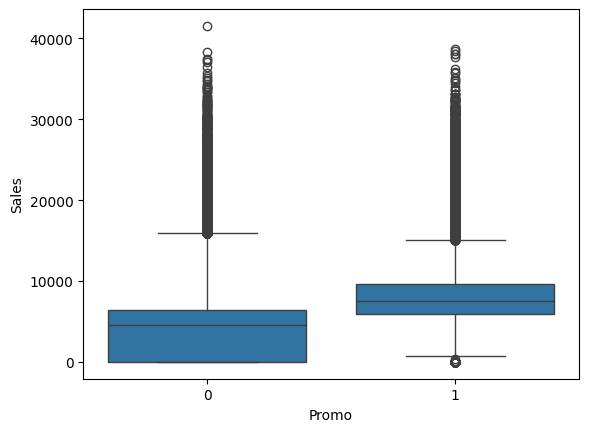

In [11]:
sns.boxplot(x='Promo', y='Sales', data=merged_df)

<Axes: xlabel='SchoolHoliday', ylabel='Sales'>

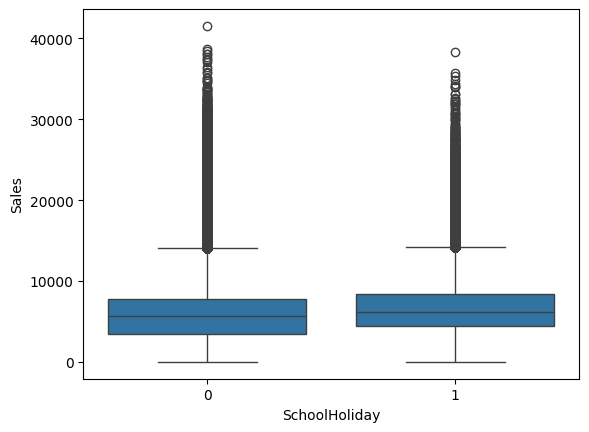

In [12]:
sns.boxplot(x='SchoolHoliday', y='Sales', data=merged_df)

Feature Engineering

Split the Date column into Year, Month, Day, WeekofeYear

In [13]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [14]:
split_date(merged_df)
split_date(merged_test_df)

Choose the days when Store was open

In [15]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [16]:
merged_df.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
305858,349,6,2014-10-18,7979,807,1,0,0,0,c,...,4.0,2009.0,0,NaN,NaN,NaN,2014,10,18,42
500649,800,3,2014-04-09,4187,441,1,0,0,0,d,...,7.0,2014.0,0,NaN,NaN,NaN,2014,4,9,15
764120,16,4,2013-08-15,7126,839,1,1,0,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,8,15,33
530673,719,4,2014-03-13,3467,298,1,0,0,0,c,...,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",2014,3,13,11
851593,519,3,2013-05-29,5533,573,1,1,0,0,c,...,8.0,2009.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",2013,5,29,22
453424,405,3,2014-05-21,4186,460,1,1,0,0,a,...,4.0,2008.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,5,21,21
549406,497,1,2014-02-24,7596,1096,1,0,0,0,a,...,NaN,NaN,0,NaN,NaN,NaN,2014,2,24,9
465372,88,6,2014-05-10,2086,220,1,0,0,0,a,...,10.0,2005.0,0,NaN,NaN,NaN,2014,5,10,19
187572,253,5,2015-02-13,5182,722,1,0,0,0,a,...,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",2015,2,13,7
369990,1003,1,2014-08-11,5140,627,1,0,0,1,a,...,7.0,2013.0,1,27.0,2013.0,"Jan,Apr,Jul,Oct",2014,8,11,33


Determine how long did the competition store was open for (in months)

In [17]:
def comp_months(df):
    df['CompOpenSince'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])
    df['CompOpenSince'] = df['CompOpenSince'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [18]:
comp_months(merged_df)
comp_months(merged_test_df)

In [19]:
merged_df.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompOpenSince
632900,366,3,2013-12-11,6457,611,1,0,0,0,d,...,2004.0,0,NaN,NaN,NaN,2013,12,11,50,108.0
300477,617,5,2014-10-24,7482,701,1,1,0,1,a,...,NaN,1,9.0,2011.0,"Jan,Apr,Jul,Oct",2014,10,24,43,0.0
9040,121,4,2015-07-23,3895,437,1,0,0,1,a,...,2009.0,1,36.0,2013.0,"Mar,Jun,Sept,Dec",2015,7,23,30,68.0
1717,603,4,2015-07-30,8713,1113,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,30,31,99.0
402651,933,1,2014-07-07,6597,886,1,0,0,0,a,...,2005.0,0,NaN,NaN,NaN,2014,7,7,28,113.0
858094,330,4,2013-05-23,2915,389,1,0,0,0,a,...,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,5,23,21,0.0
62018,694,6,2015-06-06,8583,838,1,0,0,0,a,...,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2015,6,6,23,31.0
196086,962,5,2015-02-06,7759,1039,1,1,0,0,c,...,NaN,0,NaN,NaN,NaN,2015,2,6,6,0.0
77614,680,6,2015-05-23,5192,767,1,0,0,0,c,...,NaN,1,35.0,2012.0,"Mar,Jun,Sept,Dec",2015,5,23,21,0.0
841624,585,5,2013-06-07,7529,1120,1,1,0,0,d,...,2014.0,0,NaN,NaN,NaN,2013,6,7,23,0.0


In [20]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

    try:
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

In [21]:
def promo_cols(df):
    df['Promo2OpenSince'] = 12 * (df['Year'] - df['Promo2SinceYear']) + (df['WeekOfYear'] - df['Promo2SinceWeek']) // 4
    df['Promo2OpenSince'] = df['Promo2OpenSince'].map(lambda x:0 if x<0 else x).fillna(0) * df['Promo2']
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [22]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [23]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompOpenSince', 'Promo2OpenSince', 'IsPromo2Month'],
      dtype='object')

Separate input columns and target column

In [24]:
input_cols = ['Store', 'DayOfWeek', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompOpenSince', 'Promo2OpenSince', 'IsPromo2Month', 'Year', 'Month', 'Day', 'Promo2', 'WeekOfYear']
target_col = 'Sales'

In [25]:
train_inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [26]:
test_inputs = merged_test_df[input_cols].copy()

Separate numerical and categorical columns

In [27]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompOpenSince', 'Promo2', 'Promo2OpenSince', 'IsPromo2Month', 'Day', 'Month', 'Year', 'WeekOfYear']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

Fill the missing values for Competition Distance

In [28]:
max_distance = train_inputs['CompetitionDistance'].max()

In [29]:
train_inputs['CompetitionDistance'] = train_inputs['CompetitionDistance'].fillna(max_distance*2)
test_inputs['CompetitionDistance'] = test_inputs['CompetitionDistance'].fillna(max_distance*2)

Scaling

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [31]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Encoding

In [32]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])

In [33]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Model training

In [34]:
X = train_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [39]:
from xgboost import XGBRegressor

In [40]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [41]:
model.fit(X, targets)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [42]:
predictions = model.predict(X)

In [46]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

In [47]:
rmse(predictions, targets)

np.float64(2375.5097347727287)

In [48]:
importance_df = pd.DataFrame({
    'feature' : X.columns,
    'importance' : model.feature_importances_
}).sort_values('importance', ascending=False)

<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

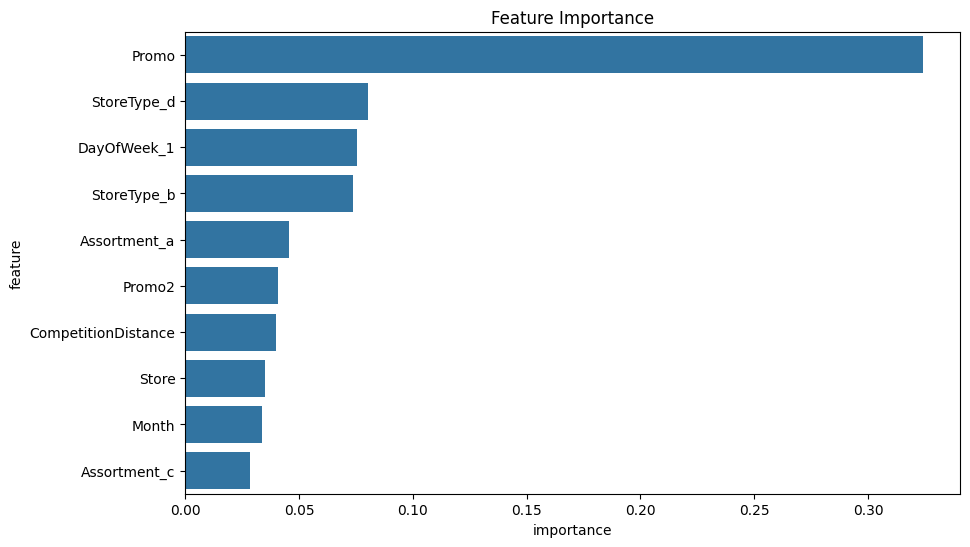

In [49]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

In [50]:
from sklearn.model_selection import KFold

In [51]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [52]:
kfold = KFold(n_splits=5)

In [53]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                    train_targets,
                                                    X_val, 
                                                    val_targets,
                                                    max_depth = 4, 
                                                    n_estimators = 20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2365.3358112538695, Validation RMSE: 2430.243712058525
Train RMSE: 2404.052724047457, Validation RMSE: 2440.2188426450607
Train RMSE: 2375.756932011354, Validation RMSE: 2351.086131982408
Train RMSE: 2385.036058427629, Validation RMSE: 2492.5219156508933
Train RMSE: 2337.7660276426295, Validation RMSE: 2416.6766436575663


In [54]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [55]:
preds = predict_avg(models, X)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size = 0.1)

def test_params(**params):
    model = XGBRegressor(random_state=42, n_jobs = -1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Val RMSE: {}'.format(train_rmse, val_rmse))

In [57]:
test_params(n_estimators=10)

Train RMSE: 2370.7339580813364, Val RMSE: 2377.104541243401


In [58]:
test_params(n_estimators=30)

Train RMSE: 1853.2696107150734, Val RMSE: 1862.1491615872237


In [59]:
test_params(n_estimators=100)

Train RMSE: 1179.9777540275918, Val RMSE: 1191.8142682482032


In [60]:
test_params(n_estimators=200)

Train RMSE: 955.3723423356989, Val RMSE: 971.1061025964156


In [61]:
test_params(n_estimators=400)

Train RMSE: 808.8661817630899, Val RMSE: 835.5870690717994


In [62]:
test_params(n_estimators=600)

Train RMSE: 744.4069367624136, Val RMSE: 781.5099167636967


In [63]:
test_params(max_depth=2, n_estimators=10)

Train RMSE: 2688.0112536966803, Val RMSE: 2687.9153632508596


In [64]:
test_params(max_depth=10, n_estimators = 100)

Train RMSE: 668.3704764200764, Val RMSE: 771.8716700333028


In [65]:
model = XGBRegressor(random_state=42, n_jobs = -1, n_estimators = 800, max_depth = 10)

In [66]:
model.fit(X, targets)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [67]:
test_preds = model.predict(X_test)

In [68]:
submission_df['Sales'] = test_preds

In [69]:
train_preds = model.predict(X)

In [70]:
rmse(train_preds, targets)

np.float64(347.63086564630595)

In [71]:
import pickle

In [72]:
with open('../models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)  
with open('../models/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)